# Load module

In [1]:
import sys
sys.path.append('../')

from data import datasets
from data import transforms, target_transforms, utils

from ssd.models.ssd300 import SSD300
from ssd.train import *

#from torchvision import transforms > not import!!
from torch.utils.data import DataLoader
from torch.optim.sgd import SGD
from torch.optim.adam import Adam

# Load Dataset

In [2]:
transform = transforms.Compose(
    [transforms.Normalize(rgb_means=(103.939, 116.779, 123.68), rgb_stds=1),
     transforms.Resize((300, 300)),
     transforms.ToTensor()]
)
target_transform = target_transforms.Compose(
    [target_transforms.Ignore(difficult=True),
     target_transforms.ToCentroids(),
     target_transforms.OneHot(class_nums=datasets.VOC_class_nums),
     target_transforms.ToTensor()]
)
train_dataset = datasets.Compose(datasets.VOC_class_nums, datasets=(datasets.VOC2007Dataset, datasets.VOC2012_TrainValDataset),
                                 transform=transform, target_transform=target_transform)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          collate_fn=utils.batch_ind_fn)
print('{} training images'.format(len(train_dataset)))

21503 training images


# Define model

In [3]:
model = SSD300(class_nums=train_dataset.class_nums, batch_norm=False)
#model.load_vgg_weights()
print(model)

SSD300(
  (_codec): Codec(
    (encoder): Encoder()
    (decoder): Decoder()
  )
  (feature_layers): ModuleDict(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_1): ReLU()
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1_2): ReLU()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_1): ReLU()
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2_2): ReLU()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_1): ReLU()
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3_2): ReLU()
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

# Set matplotlib for Jupyter notebook

In [4]:
%matplotlib notebook

# Run training

<IPython.core.display.Javascript object>


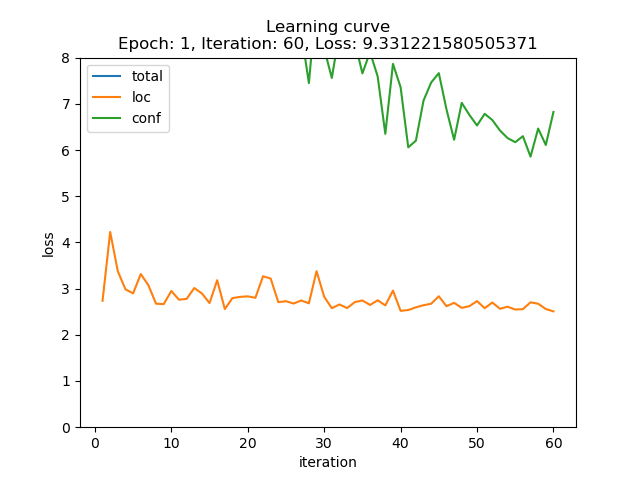

Training... Epoch: 1, Iter: 69,	 [2208/21503	 (10%)]	Loss: 9.075362, Loc Loss: 2.580888, Conf Loss: 6.4944749

In [ ]:
#optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4) # late
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
iter_sheduler = SSDIterStepLR(optimizer, step_size=60000, gamma=0.1, verbose=True)

save_manager = SaveManager(modelname='ssd300-voc2007+2012', interval=5000, max_checkpoints=15, plot_yrange=(0, 8))
log_manager = LogManager(interval=10, save_manager=save_manager, live_graph=LiveGraph((0, 8)))
trainer = TrainLogger(model, loss_func=SSDLoss(), optimizer=optimizer, scheduler=iter_sheduler, log_manager=log_manager, gpu=True)

#trainer.train(70, train_loader)
trainer.train(80000, train_loader)

# ↑Final model not saving.........Bug......................